In [68]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss
from utils.uniform_models import ZeroOutput

from toy_models.parallel_serial_network import CustomMLP
from torch import Tensor

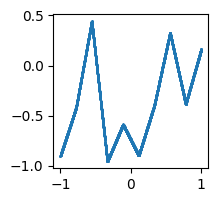

In [71]:
piecewise_data_path = "../outputs/toy_models/piecewise_training_data.pt"
piecewise_data = torch.load(piecewise_data_path)
x = np.array([x.item() for x,_ in piecewise_data])
y = np.array([y.item() for _,y in piecewise_data])
plt.figure(figsize=(2,2))
plt.plot(x,y, '.', markersize=1)

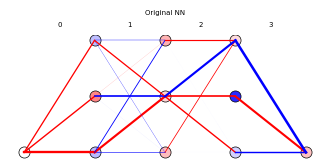

In [72]:
# Load TMS model
piecewise_model_path = "../outputs/toy_models/piecewise.pt"


piecewise_network = torch.load(piecewise_model_path)['model']


model_params = dict(piecewise_network.named_parameters())
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")


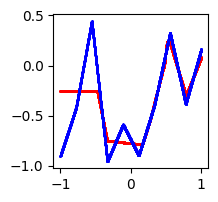

In [74]:
x = np.array([x.item() for x,_ in piecewise_data])
y = np.array([y.item() for _,y in piecewise_data])

y_pred = piecewise_network(Tensor([x]).transpose(0,1).to('cuda')).detach().cpu().numpy()
plt.figure(figsize=(2,2))
plt.plot(x, y_pred, 'r.', markersize=1)

plt.plot(x,y, 'b.', markersize=1)
plt.show()

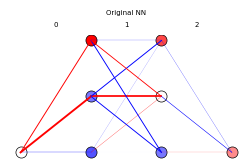

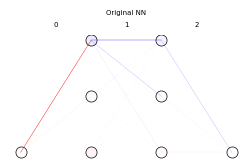

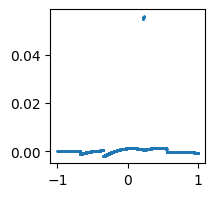

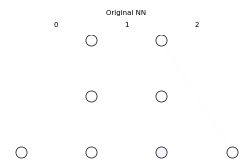

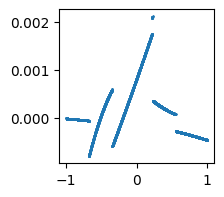

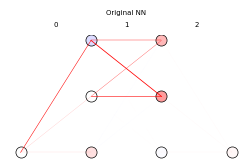

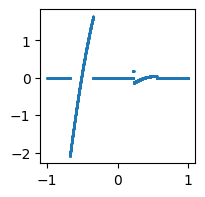

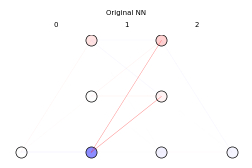

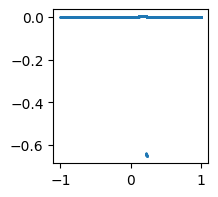

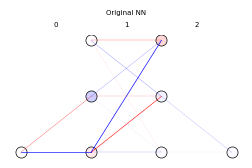

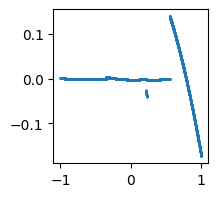

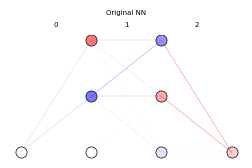

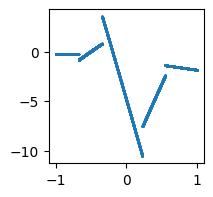

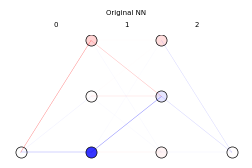

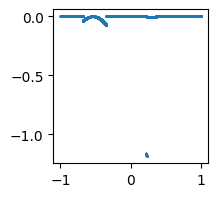

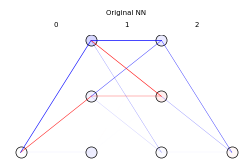

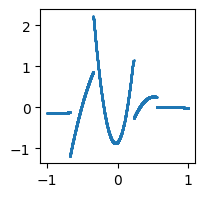

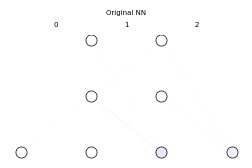

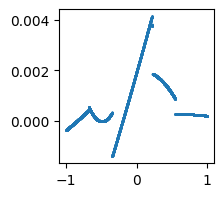

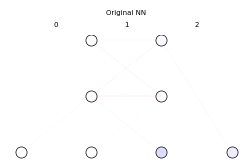

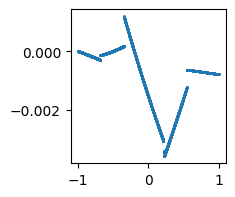

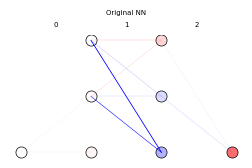

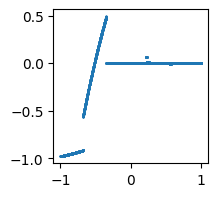

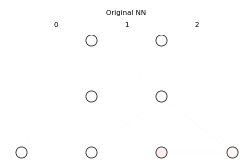

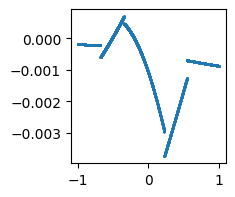

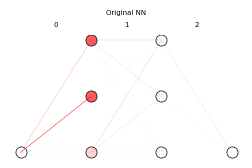

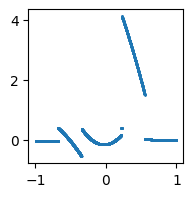

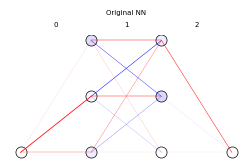

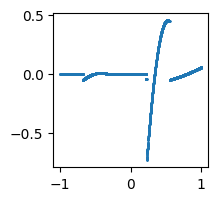

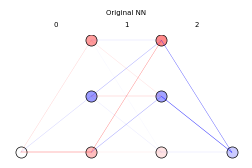

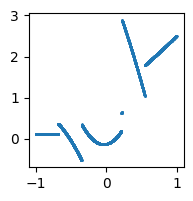

In [64]:
eigenmodel_path = "../outputs/eigenmodels/piecewise.pt"


checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

X = 2*torch.rand(10000,1).to('cuda')-1
feature_vals = eigenmodel(eigenmodel.compute_jacobian(X))


for i, network in enumerate(eigenmodel.construct_subnetworks()):
    
    weights = {k:v for k,v in network.items() if 'bias' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'bias' in k}
    biases = {str(i):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases, "Original NN")

    plt.figure(figsize=(2,2))
    plt.plot(X.detach().cpu().numpy(), feature_vals[:,i].detach().cpu().numpy(), '.', markersize=1)
    plt.show()


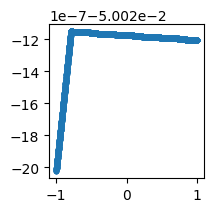

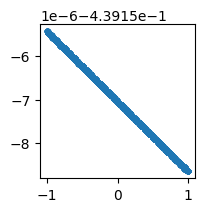

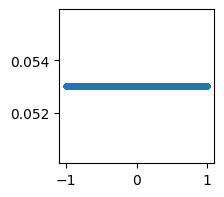

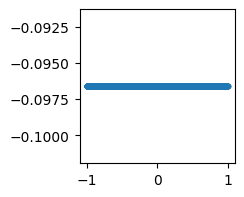

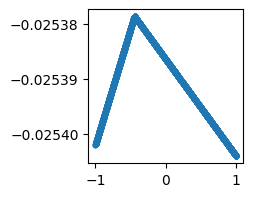

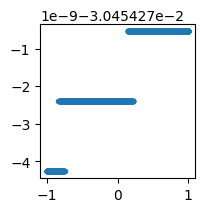

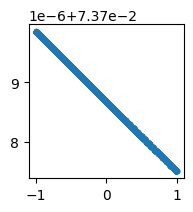

In [21]:
new_model = copy.deepcopy(eigenmodel.model)

for i, network in enumerate(eigenmodel.construct_subnetworks()):

    new_model.load_state_dict(network)
    y = new_model(X).cpu().detach().numpy()
    plt.figure(figsize=(2,2))
    plt.plot(X.cpu().detach().numpy(), y, '.')
    plt.show()